In [1]:
import linopy
import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import cartopy
import cartopy.crs as ccrs

import networkx as nx

from atlite.gis import ExclusionContainer, shape_availability
from rasterio.plot import show
from rasterio.crs import CRS
import rasterio as rio

from pathlib import Path

all data provided from TU Berlin can be found here:
https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq

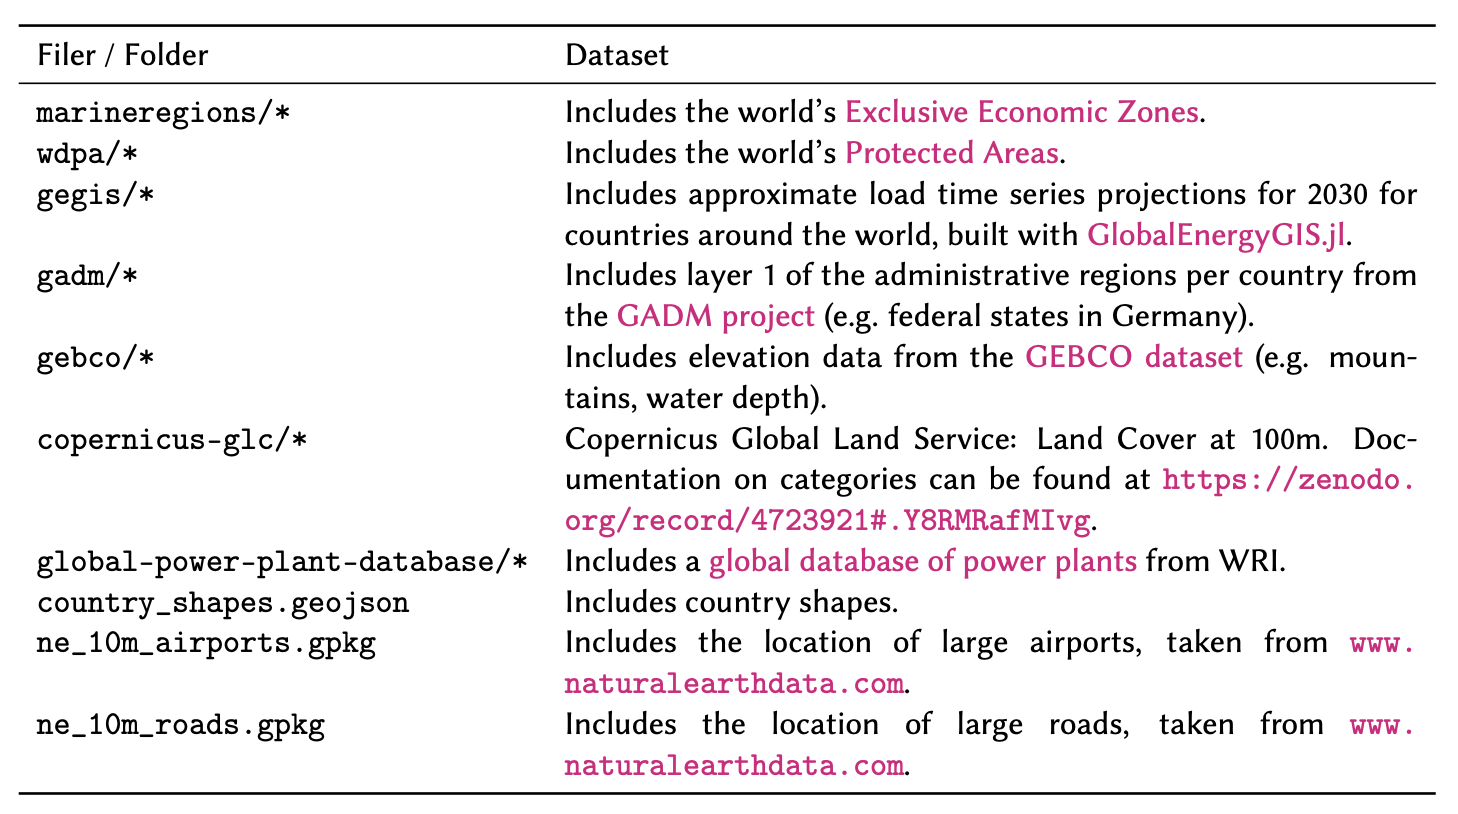

also data on technology and cost assumptions can be found here: https://github.com/PyPSA/technology-data/tree/master/outputs 

global power plant database: https://datasets.wri.org/datasets/global-power-plant-database

In [72]:
url_countries = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"

url_airports = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg"
url_roads = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg"
url_gadm = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-IRN.gpkg"
url_eez = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fmarineregions%2FWorld_EEZ_v11_20191118_gpkg&files=eez_v11.gpkg"

url_wdpa = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-IRN.tif"

url_gebco = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-IR.nc"

url_load = Path("data") / "load.csv"

url_power_plants = Path("data") / "global_power_plant_database.csv"

url_glc = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-IR.tif"

COST_YEAR = 2020
url_costs = Path("data") / f"costs_{COST_YEAR}.csv"

## getting the shape of the country

In [3]:
countries = gpd.read_file(url_countries).set_index("name")

# storing shape of the country so it can be used in further steps
shape_ir = countries.to_crs(epsg=3035).loc[["IR"]].geometry

## preparing exclusive economics zone EEZ and states of iran GADM

In [4]:
# preparing the exclusive economice zone of Iran for Wind off-shore analysis
eez = gpd.read_file(url_eez)
eez_ir = eez[eez["SOVEREIGN1"] == "Iran"]
eez_ir

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
162,8469.0,Iranian Exclusive Economic Zone,2126.0,200NM,2126.0,Iran,IRN,Iran,0.0,0.0,...,IRN,None,None,364,NaN,NaN,364.0,NaN,NaN,"MULTIPOLYGON (((56.087 27.10831, 56.08874 27.1..."


In [5]:
# preparing the data of states of Iran
gadm_ir = gpd.read_file(url_gadm)
gadm_ir["bus"] = gadm_ir.geometry.centroid # to be used as bus for modeling
#gadm_ir

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_42544/936548394.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



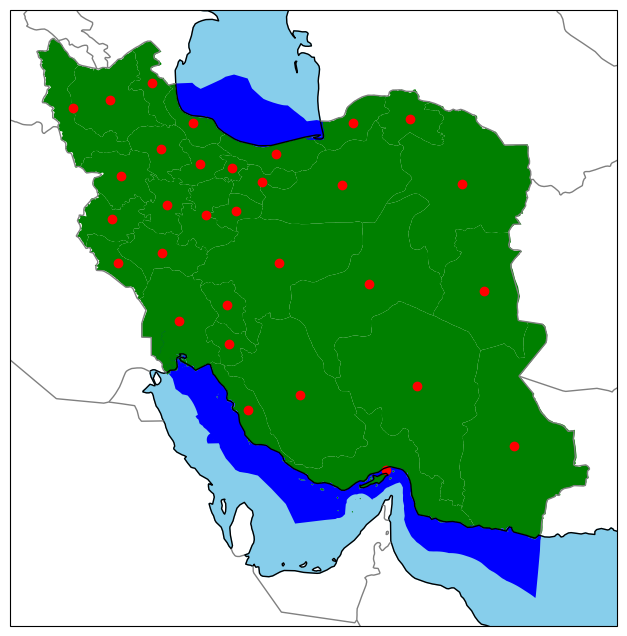

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

gadm_ir.plot(ax=ax, color="green")
eez_ir.plot(ax=ax, color="blue")
gadm_ir.bus.plot(ax=ax, color="red") # center of each state to be used as bus for modelling

ax.coastlines()

#ax.set_extent([44, 64, 24, 41], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, color="gray")
ax.add_feature(cartopy.feature.OCEAN, color="skyblue")
#ax.add_feature(cartopy.feature.LAND, color="lightgreen")

## world's protected areas from WDPA

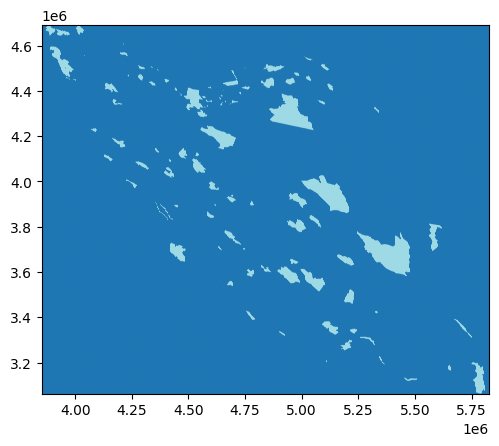

<Axes: >

In [7]:
# world's protected areas
wdpa_ir = rio.open(url_wdpa)
band_wdpa = wdpa_ir.read(1)

show(band_wdpa, transform=wdpa_ir.transform, cmap="tab20")

## Elevation Data from GEBCO dataset

/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



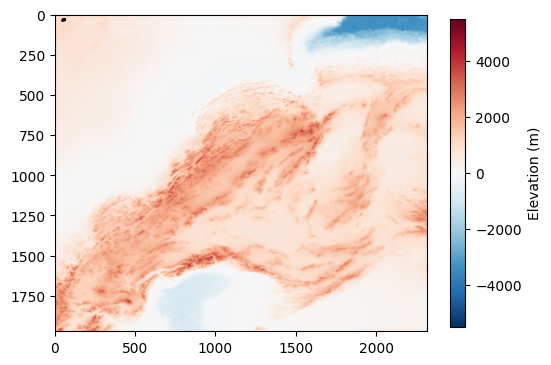

In [9]:
import os
os.environ["GDAL_SKIP"] = "netCDF"

gebco_ir = rio.open(url_gebco, driver="HDF5")
band_gebco = gebco_ir.read(1)

#gebco_ir.crs = CRS.from_epsg(4326)

fig, ax = plt.subplots(figsize=(6, 8))

shape_ir.to_crs(4326).boundary.plot(ax=ax, color="black", linewidth=1)

show(band_gebco, transform=gebco_ir.transform, cmap="RdBu_r", ax=ax, vmin=-5500, vmax=5500)

plt.colorbar(ax.images[0], ax=ax, label="Elevation (m)", shrink=0.5)

# is the orientation correct??????????????

In [65]:
# is the orientation correct??????????????

## Load Time Seires

In [10]:
# load time series for whole year of 2013
url_load = Path("data") / "load.csv"
load = pd.read_csv(url_load, index_col=0, parse_dates=True)
load_ir = load.IR
load_ir # in MW

time
2013-01-01 00:00:00    44632.674337
2013-01-01 01:00:00    46537.259915
2013-01-01 02:00:00    52027.177061
2013-01-01 03:00:00    54580.901243
2013-01-01 04:00:00    55919.248085
                           ...     
2013-12-31 19:00:00    52289.036304
2013-12-31 20:00:00    45634.742724
2013-12-31 21:00:00    44229.819813
2013-12-31 22:00:00    43648.310049
2013-12-31 23:00:00    43385.474069
Name: IR, Length: 8760, dtype: float64

## Power-Plant Data

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_42544/154041461.py:1: DtypeWarning:

Columns (10,17,18,26,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



Text(0.5, 1.0, 'Location of power plants and their primary fuel')

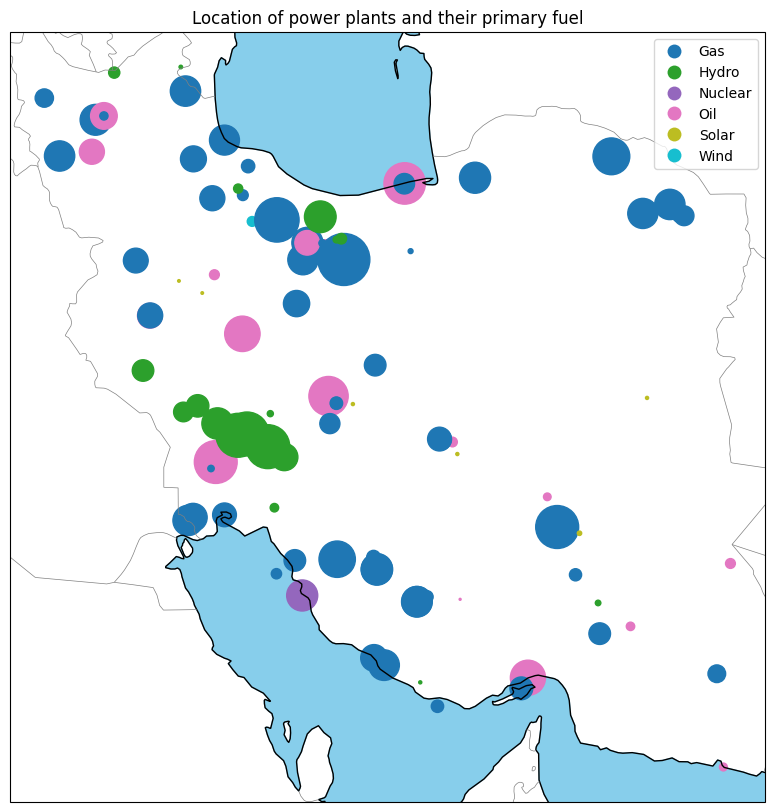

In [68]:
pp = pd.read_csv(url_power_plants)
pp = pp[pp["country"] == "IRN"]

geometry = gpd.points_from_xy(pp.longitude, pp.latitude) # saving geometry from long and lat of the data to create a geopanda

pp_ir = gpd.GeoDataFrame(pp, geometry=geometry, crs="WGS84")

# Plot them
fig = plt.figure(figsize=(15, 10)) 
ax = plt.axes(projection = ccrs.epsg(3857))

pp_ir.to_crs(epsg=3857).plot(
    ax = ax,
    column = "primary_fuel",
    markersize = pp_ir["capacity_mw"]/2, # deviding by 2 for better illustration
    legend=True,
)

ax.coastlines()

ax.add_feature(cartopy.feature.OCEAN, color="skyblue")
ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#ax.add_feature(cartopy.feature.LAKES, color="skyblue")
#ax.set_extent([44, 64, 24, 41], crs=ccrs.PlateCarree())

ax.set_title("Location of power plants and their primary fuel") 

## Copernicus GLC

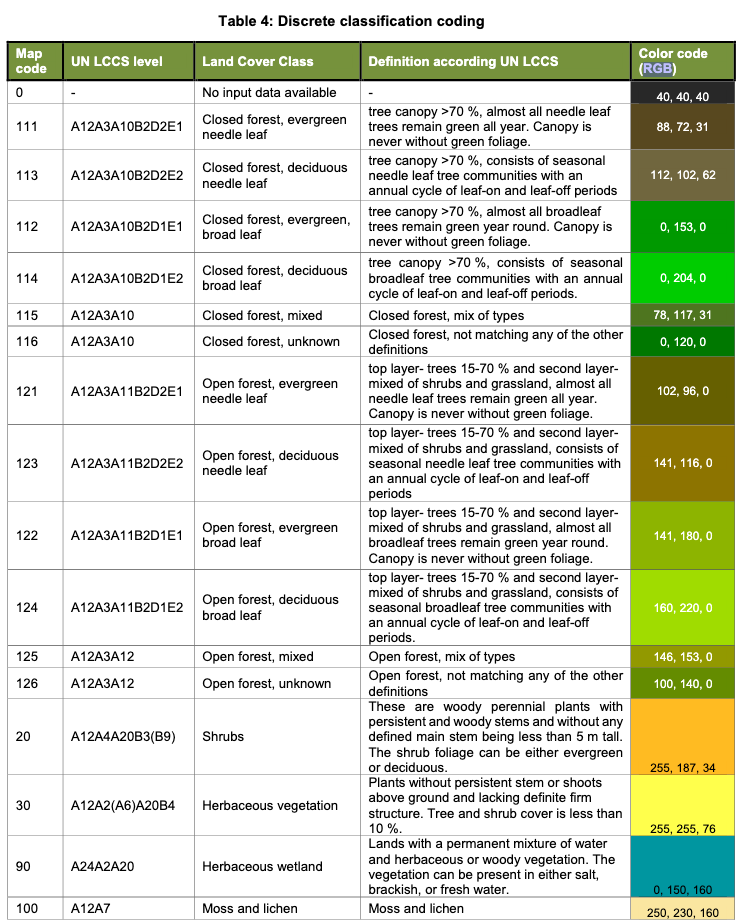
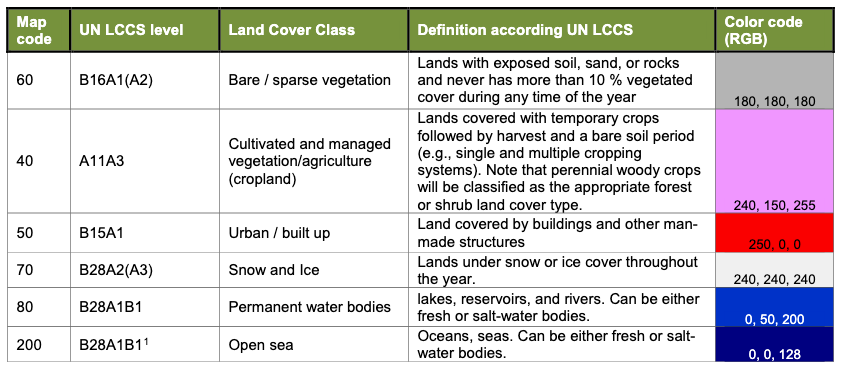

in these two tables above, the classification is documented

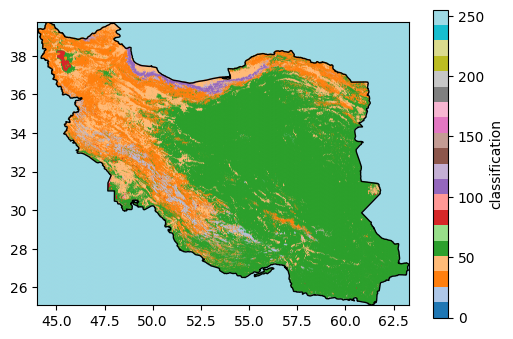

In [66]:
# world's protected areas
glc_ir = rio.open(url_glc)
band_glc = glc_ir.read(1)

fig, ax = plt.subplots(figsize=(6, 8))

shape_ir.to_crs(4326).boundary.plot(ax=ax, color="black", linewidth=1)

show(band_glc, transform=glc_ir.transform, cmap="tab20", ax=ax)

plt.colorbar(ax.images[0], ax=ax, label="classification", shrink=0.5)

In [ ]:
## Classification noch genauer beschreiben und labeln

## Costs (remember to select the year from 2020 to 2050)

In [77]:
# you can adjust the year, you want the cost to be projected to from 2020 to 2050 (at the beginning in COST_YEAR variable)
costs = pd.read_csv(url_costs)
costs

,technology,parameter,value,unit,source,further description,currency_year
0,Alkaline electrolyzer large size,FOM,6.4000,%/year,"JRC, 01_JRC-EU-TIMES Full model, https://zenod...",Reference capacity 72 MW,2010.0
1,Alkaline electrolyzer large size,VOM,0.6142,EUR/MWh_H2,"JRC, 01_JRC-EU-TIMES Full model, https://zenod...",Reference capacity 72 MW,2010.0
2,Alkaline electrolyzer large size,electricity-input,1.5000,MWh_el/MWh_H2,"JRC, 01_JRC-EU-TIMES Full model, https://zenod...",Reference capacity 72 MW,NaN
3,Alkaline electrolyzer large size,investment,711.9042,EUR/kW,"JRC, 01_JRC-EU-TIMES Full model, https://zenod...",Reference capacity 72 MW,2010.0
4,Alkaline electrolyzer large size,lifetime,40.0000,years,"JRC, 01_JRC-EU-TIMES Full model, https://zenod...",Reference capacity 72 MW,NaN
...,...,...,...,...,...,...,...
1234,waste CHP CC,efficiency-heat,0.7635,per unit,"Danish Energy Agency, inputs/technology_data_f...","08 WtE CHP, Large, 50 degree: Heat efficiency...",2015.0
1235,waste CHP CC,investment,9077.1074,EUR/kW_e,"Danish Energy Agency, inputs/technology_data_f...","08 WtE CHP, Large, 50 degree: Nominal investm...",2015.0
1236,waste CHP CC,lifetime,25.0000,years,"Danish Energy Agency, inputs/technology_data_f...","08 WtE CHP, Large, 50 degree: Technical lifetime",2015.0
1237,water tank charger,efficiency,0.9000,per unit,HP,from old pypsa cost assumptions,2015.0
